# Tutorial: Tomography Reconstruction using PhaseT3M

### Import libraries

In [1]:
from matplotlib import pyplot as plt
import scipy.io as sio
import numpy as np
import cupy as cp
import PhaseT3M

print('PhaseT3M_version: {}'.format(PhaseT3M.__version__))
print('cupy: {}'.format(cp.cuda.is_available()))

PhaseT3M_version: 0.0.1
cupy: True


### Read tilt data and meta data

In [2]:
import h5py

with h5py.File('./data/Pt_tilt_series.h5','r') as hf:
    #print(hf.keys())
    tilt_data = np.array(hf.get('tilt_series'))
    tilt_angles = np.array(hf.get('tilt_angles'))
    defocus_values = np.array(hf.get('defocus_values'))
    pixel_size = np.array(hf.get('pixel_size'))+0
    energy = np.array(hf.get('energy'))

### Create rotation matrix

In [3]:
from scipy.spatial.transform import Rotation

rotations = Rotation.from_rotvec(
    np.pad(
        tilt_angles[:,None],
        ((0,0),(0,2))
    ),
    degrees=True
)

tilt_orientation_matrices = rotations.as_matrix()

### Make input data for reconstruction

In [4]:
tilt_dataset = []
for i1 in range(tilt_data.shape[0]):
        datastack = PhaseT3M.DataStack(data = tilt_data[i1],
                                   defocus = defocus_values)
        tilt_dataset.append(datastack)

### Reconstruction

Reconstructing object: 100%|██████████| 50/50 [00:58<00:00,  1.17s/ iter]


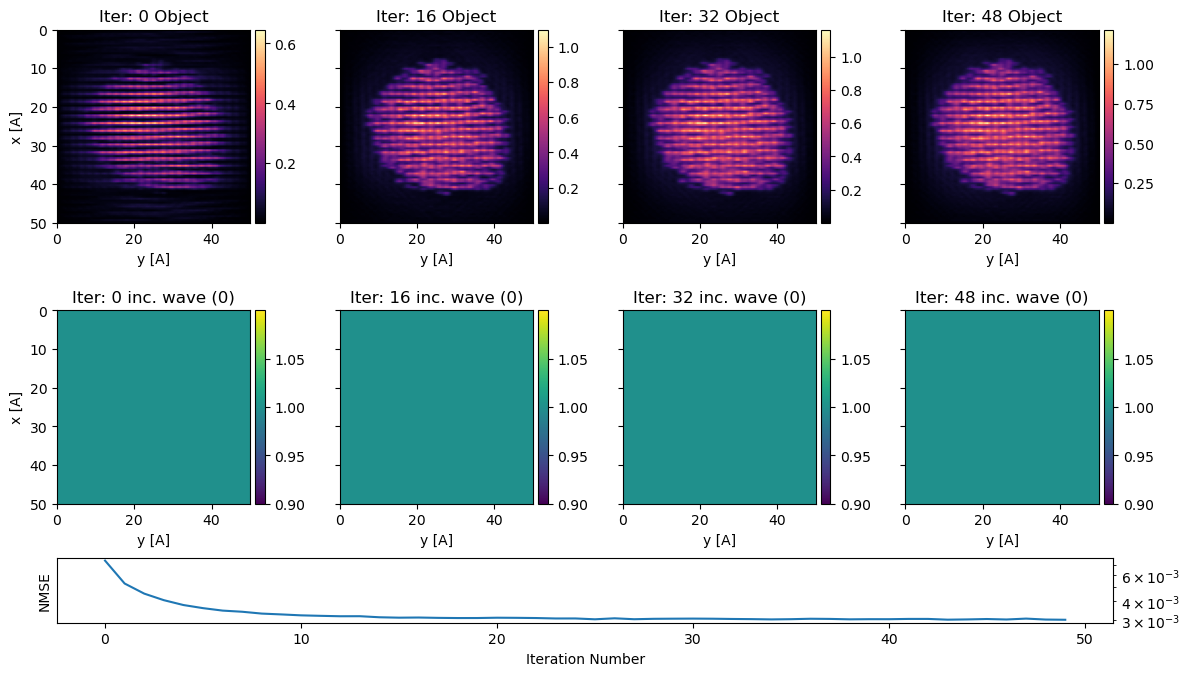

In [5]:
PhaseTEM_recon = PhaseT3M.process.TomographicReconstruction(
        datastack = tilt_dataset,
        energy = energy,
        num_slices = 25, # 1 -> SingleSliceReconstruction, more than 1 -> MultiSliceReconstruction
        pixel_size = pixel_size, # Angstrom
        tilt_orientation_matrices= tilt_orientation_matrices,
        device= "gpu", # "cpu" or "gpu"
        object_type='potential', # 'potential' or 'complex'
        ).preprocess(
        ).reconstruct(
        reset = True,
        num_iter = 50,
        step_size = 0.01,
        collective_tilt_updates = False,
        store_iterations=True,
        object_positivity = True,
        ).visualize(
        iterations_grid = 'auto',
        plot_nth_incident_wave = 0,
        )